# Population Simulation: Type 1 Diabetes
Timothy Novak and Maia Materman

The following section of code recreates the population model from the ModSim Notebooks. This code is here primarily for reference.

Saving figure to file chap04-fig01.pdf


7.6546433958074465

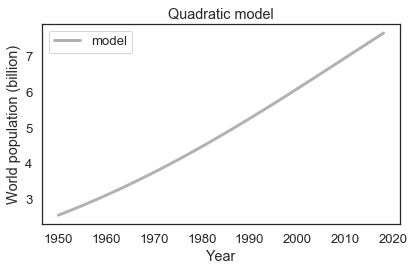

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import code libraries
from modsim import *
import random
import math

from pandas import read_html
def plot_results(timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """

    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)
def run_population_growth_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

def update_func_quad(pop, t, system):
    """Update population based on a quadratic model.
    
    pop: current population in billions
    t: what year it is
    system: system object with model parameters
    """
    net_growth = system.alpha * pop + system.beta * pop**2
    return pop + net_growth

population_growth_system = System(t_0=1950, 
                t_end=2018,
                p_0=2.557628654,
                alpha=0.025,
                beta=-0.0018)
population_growth_results = run_population_growth_simulation(population_growth_system, update_func_quad)
plot_results(population_growth_results, 'Quadratic model')
savefig('chap04-fig01.pdf')
population_growth_results[population_growth_system.t_end]

A newer and better question:
Are genetic factors suficent to explain the recent increase in percent population with type 1 diabeties?

### Initial Conditions and System Variable Set Up
We first need to look at initial conditions and system inputs.

In [2]:
#Initialize System with various transmission percentages and inital populations of type 1 diabetics, carrying and neutral individuals
system = System(initpop = 6236068, percent_safe_pop =.9653 , percent_carry_pop =.0345, percent_sick_pop = .0002, death_rate = .0074)
state = State(year = 2018)
#create 2d array of transmission rates
#the output array is as follows
#   MM  Mm  mm
#FF.01 .01 .10
#Ff.01 .02 .10
#ff.04 .04 .14
transmission_rates = [[.01,.01,.1],[.01,.02,.1],[.04,.04,.14]]

[[0.01, 0.01, 0.1], [0.01, 0.02, 0.1], [0.04, 0.04, 0.14]]

### Setting Up the Initial Populations
We will take the each of the initial populations of the group and divide them into two groups on the basis of sex. One is made to represent males and the other is made to represent females. Interestingly enough, the propagation rates of the disorder vary by sex of the parents.

We will now assign each human one of three states:

0: A person who does not have any of the transmission genes 

1: A person who is a carrier of the disorder but does not have it 

2: A person who has the disorder

In [3]:
#create arrays of people
female = []
male = []
#divide relative populations by two to find the number of males and females for each group then divide by 100,000 so that each person in the array is representative of 100,000 people
for i in range(math.ceil((system.initpop * system.percent_safe_pop)/2/100000)):
    female.append(0)
    male.append(0)
for j in range(math.ceil((system.initpop* system.percent_carry_pop)/2/100000)):
    female.append(1)
    male.append(1)
for k in range(math.ceil((system.initpop* system.percent_sick_pop)/2/100000)):
    female.append(2)
    male.append(2)

It is important to note that to conserve memory and time when running simulations, each 'person' in the arrays is representative of 100,000 people.
When we start accounting for deaths, it will be important that the arrays are randomized.

In [4]:
#scramble the arrays
random.shuffle(female)
random.shuffle(male)

### Breeding Algorithm
For each time step we will need to breed our population. For this reason, we need to create a breeding algorithm. We will assume that each male has an equal chance of being paired with any female. So we will start by picking a random male and a random female.

In [5]:
#generate a random male and a random female
randommale = male[random.randint(0,len(male))]
randomfemale = female[random.randint(0,len(female))]

0

Now, we will mate the individuals. We assume that one person will be formed from every couple. We then use the flip function to determine whether the child has the disorder, is a carrier, or has no relation to the disorder. We found the values which we put in our flip function from research on type 1 diabetes. We also assume that there is an equal probability of the child being either male or female.

In [6]:
#generate a child and assign a trait to it and append it to the relevant array
print(female,male)
child = 0
#apply transmission rates
if flip(transmission_rates[randomfemale][randommale]):
    child = 2
elif flip(system.percent_carry_pop):
    child = 1
else:
    child = 0
#assign sex
if flip(.5):
    female.append(child)
else:
    male.append(child)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


That breeding function is the heart of our model. At this point, it makes sense to encapsulate it into a mate function.

In [7]:
#encapsulate the code above into a function
def mate (system, state, male, female, transmission_rates):
    "This function performs a random mating algorithm which mates one male and one female. It takes a system variable which stores percent carrying rate for a genitic disorder. male and female are arrays which store the population of males and females in the simulation. Transmission rates is a 3X3 matrix which holds the relative propagation rates of various pairings of parents"
    #generate a random male and a random female
    randommale = male[random.randint(0,len(male)-1)]
    randomfemale = female[random.randint(0,len(female)-1)]
    #generate a child and assign a trait to it and append it to the relevant array
    
    child = 0
    #apply the transmission rates
    if flip(transmission_rates[randomfemale][randommale]):
        child = 2
    elif flip(system.percent_carry_pop):
        child = 1
    else:
        child = 0
    #make sex
    if flip(.5):
        female.append(child)
    else:
        male.append(child)
   # print (female)
    #print (male)
    
mate (system, state, male, female, transmission_rates)

### Time Step
Now we can start making our update function that gets run every time step. At the start of our time step we want to generate a number of babies which correlates to the growth rate of the population.

In [8]:
growthrate = .01
#make a loop which generates a number of kids by running it in proportion to the growthrate + death rate
for growthcounter in range(math.ceil((growthrate + system.death_rate)*(len(male)+len(female)))):
    
    #perform breeding algorithm
    mate (system, state, male, female, transmission_rates)


Before we go on, it is important to note that in the previous code, we generate children equal to the growth rate + the death rate because the growth rate is actually the net growth rate (living people - dead people). This is necessary to consider when we make new people.

Although this seems good it this falls into the problem that our very first model of population this semester fell into: it assumes a constant growth rate. For this reason, we need to write another function which retrieves a growth rate from our total Austrian population model created earlier.

In [9]:
#Growth rate retrieval function
def retrieverate(year, results, population_growth_system):
    "this model takes in the results from the original population model and the curent year and will return the net growth rate between the supplied year and the previous year."
    #checks if it is the first year in the series
    if year == population_growth_system.t_0 or year > population_growth_system.t_end:
        #returns a null condition that signifies that an invalid year was inputted
         return 0
    #if it is a valid year
    elif year <= population_growth_system.t_end:
        #returns the net growth from the previous year
        return (results[year]- results[year-1])
    else:
        return 0
   

Now that we are here, there is just one more idea we need to account for in our time step: the fact that people that die off. We need to kill off people in the population according to what the death rate predicts.

In [10]:
#loops through the death rate
for deathcounter in range(math.ceil(system.death_rate*(len(female)+len(male)))):
    #if the member to be deleted is one with type 1 diabetes
    if flip(.5):
        if female[0] == 2:
            del female[0]
    else:
        if male[0] == 2:
            del male[0]

You might notice that we are handling these deaths in an odd way, by explicitly killing off the people from the begining of the array. This is because it creates population turn over. New babies are added to one end of the array and the other end of the array has the old die off. This then means that as a baby gets older it will get cycled through the array until it dies at the other end.This keeps the population from becoming stagnant when the growth rate lessens towards the carrying capacity.

Well we can now calculate the percent of the population which has the disorder by dividing the number of diabetic individuals by the total population found as the sum of the male and female arrays. We can also encapsulate the function at the end of this into an update function.

In [11]:
#make the percent population calculation and print it

def num_sick(male,female):
    sickcounter = 0
    for malecounter in male:
        if malecounter == 2:
            sickcounter +=1
    for femalecounter in female:
        if femalecounter == 2:
            sickcounter += 1
    return sickcounter
        

#Encapsulate everything into an update function
def update(system, state, year, population_growth_system, population_growth_results, male, female):
    gr = retrieverate(year, population_growth_results, population_growth_system)
    
    for r in range(0, (math.ceil((gr + system.death_rate) * (len(male))))):
        mate(system, state, male, female, transmission_rates)
            
    for deathcounter in range(math.ceil(system.death_rate*(len(female)+len(male)))):
        #if the member to be deleted is one with type 1 diabetes
        if flip(.5):
            if female[0] == 2:
                del female[0]
        else:
            if male[0] == 2:
                del male[0]
    state.year = year +1
    return (num_sick(male,female)/(len(female)+len(male)))*100
    
update(system, state, state.year, population_growth_system, population_growth_results, male, female)

2.631578947368421

### Run simulation
We can now make a pretty standard run simulation function which retuns a time series of percent populations

In [14]:
#Run simulation function which retuns a time Series
def run_genetic_disorder_sim(start_year, end_year, init_local_population):
    #creates a system which holds the values for the global population
    population_growth_system = System(t_0=start_year, 
                                      t_end=end_year,
                                      p_0=2.557628654,
                                      alpha=0.025,
                                      beta=-0.0018)
    #generates the population growth model for the entire population
    population_growth_results = run_population_growth_simulation(population_growth_system, update_func_quad)
    
    #Initialize System with various transmission percentages and initial populations of type 1 diabetics, carrying and neutral individuals
    genetic_system = System(initpop = init_local_population, percent_safe_pop =.9653 , percent_carry_pop =.0345, percent_sick_pop = .0002, death_rate = .0074)
    genetic_state = State(sickcounter = 0, year = start_year)
    #create 2d array of transmission rates
    #the output array is as follows
    #   MM  Mm  mm
    #FF.01 .01 .10
    #Ff.01 .02 .10
    #ff.04 .04 .14
    transmission_rates = [[.01,.01,.1],[.01,.02,.1],[.04,.04,.14]]
    
    #create arrays of people
    female = []
    male = []
    #divide relative populations by two to find the number of males and females for each group then divide by 100,000 so that each person in the array is representative of 100,000 people
    for i in range(math.ceil((system.initpop * system.percent_safe_pop)/2/100000)):
        female.append(0)
        male.append(0)
    for j in range(math.ceil((system.initpop* system.percent_carry_pop)/2/100000)):
        female.append(1)
        male.append(1)
    for k in range(math.ceil((system.initpop* system.percent_sick_pop)/2/100000)):
        female.append(2)
        male.append(2)
    
    percent_population_with_disorder = TimeSeries()

    for t in linrange(genetic_state.year, population_growth_system.t_end, 1):
        percent_population_with_disorder[t] = update(genetic_system, genetic_state,t, population_growth_system, population_growth_results, male, female)
        
    return percent_population_with_disorder

### Results
We can now get some results. We can plot the percent population which is diabetic over time.

Saving figure to file diabetic_percent.pdf


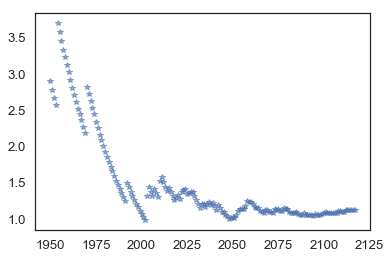

In [15]:
#Plots of percent diabetic over time
plot(run_genetic_disorder_sim(1950, 2118, 6236068),"*")
savefig('diabetic_percent.pdf')

We can also calculate the answer to our motivating question.

In [ ]:
#calculate the answer to the motivating question
#TODO

### Comaprason of data and results
An interesting result of having made two different models is that we can compare them against each other.

In [ ]:
#Comparason stuffs
#Todo

### Interpretation
Let's Interpret things!

In [ ]:
#interpretation
#TODO